### Introduction

Ever since moving to Melbourne from New York, I have been keenly aware of the lack of good Mexican food in Melbourne. As a result, I decided to webscrape Zomato.com for every review of Melbourne Mexican restaurants I could find, and tried to find the best Mexican food.

Upon scraping the reviews, I found that 3,500 of the reviews did not actually have numerical reviews scores. Instead, as a result of Zomato purchasing Urbanspoon.com in 2015, these reviews rated a restaurant as positive or negative. Zomato was encouraging former Urbanspoon users to update their reviews to reflect a numerical score. Unfortunately, this doesn't appear to be happening. 

While I still had 2,500 reviews which had text, I decided to try and make use of the Urbanspoon reviews since there are thousands of these sentiment reviews which don't contribute.

In [1]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

In [2]:
# instantiating dataframe of all webscraped data.
df = pd.read_csv('full_scrape.csv', index_col=0)

I learned so much while webscraping these reviews! Fortunately, I was able to get quite a lot of user and restaurant information in the process.

##### Columns of Interest:

- **review_id**: Unique identification number of the review.
- **review_likes**: Count of how many likes the review received.
- **user_id**: Unique identification number of the User.
- **user_url**: URL to User's page on Zomato.
- **restaurant**: Name of restaurant that was reviewed by the User
- **restaurant_id**: Unique identification number of the restaurant
- **restaurant_reviews**: Number of text reviews a restaurant has received.
- **total_reviews**: Sum of text reviews and score only (no written review) reviews.
- **num_photos**: Number of photos of the restaurant uploaded by Users
- **location**: Name of Melbourne suburb that is home to the restaurant
- **address**: Address
- **prices**: Estimated price for two people. Calculated as two mid-ranged appetizers, two mains, two drinks, and one dessert.
- **has_run**: Internal feature that I used while scraping to keep track of progress.
- **user_total_reviews**: Total number of reviews the User has written.
- **user_location**: User location.
- **user_total_photos**: Total number of photos the User has uploaded with reviews.
- **user_rank**: Number value of associated user_tier (see next column description). Higher values imply higher ranking
- **user_tier**: User's Zomato ranking.
- **user_followers**: Number of Users following User
- **user_leaderboard_rank**: Number value that tracks the User's ranking on any region-specific leaderboards, such as best photographer.
- **user_expert_hoods**: Name of location where User has reviewed enough restaurants to be awarded "expert" status by Zomato.
- **restaurant_rating**: Restaurant's advertised rating on Zomato.com.
- **restaurant_url**: Restaurant's URL.

In [3]:
# remove feature which tracked if the scraper was successful
df.drop('has_run', axis = 1, inplace = True)

# remove reviews where the scraper missed the text
df = df[df['review_text'].isnull() == False].copy()

# create new feature which gives total word count for each in each review
df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))

# make review text lowercase
df['review_text'] = df['review_text'].str.lower()

# factorize sentiment user rating entries - reviews where the score is positive or negative - as a new feature
df['positive'] = df['user_rating'].apply(lambda x: 1 if x == 'POSITIVE' else 0 if x == 'NEGATIVE' else np.nan)

# make sentiment user rating entries null now that they are in a different column
df['user_rating'] = pd.to_numeric(df['user_rating'], errors = 'coerce')

# some reviews didn't have a review score or a sentiment rating on Zomato
# make user rating entries with no score or sentiment rating null
df.loc[df['user_rating'] == 0, 'user_rating'] = np.nan

# create new feature that counts how many mexican restaurants a reviewer has reviewed
user_counts_d = pd.Series.to_dict(df['user_id'].value_counts() - 1)
df['mex_reviews'] = df['user_id'].map(user_counts_d)

In [4]:
df['user_rating'].value_counts()

5.0    576
4.0    522
4.5    467
3.5    374
3.0    212
1.0    191
2.5    131
2.0    122
1.5     98
Name: user_rating, dtype: int64

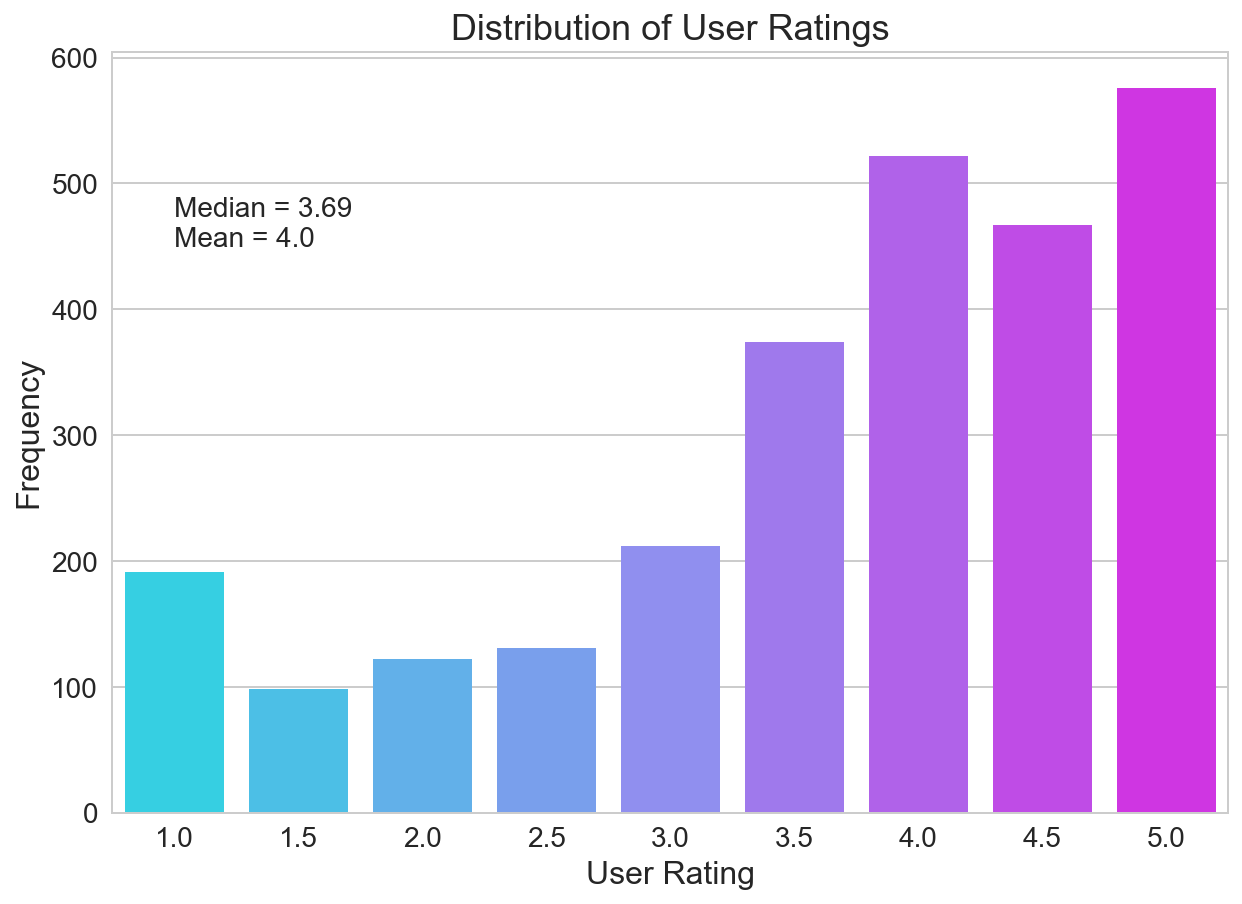

In [5]:
# plotting the distribution of user ratings
plt.figure(figsize = (10,7))
sns.countplot(x = 'user_rating', data = df, palette = 'cool')

plt.xlabel('User Rating', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Distribution of User Ratings', fontsize = 18)
plt.annotate('Median = {}\nMean = {}'.format(round(df['user_rating'].mean(), 2), 
                                             df['user_rating'].median()), xy = (0,450), fontsize = 14);

Zomato Mean = 3.75
User Mean = 3.69

Zomato Median = 3.9
User Median = 4.0


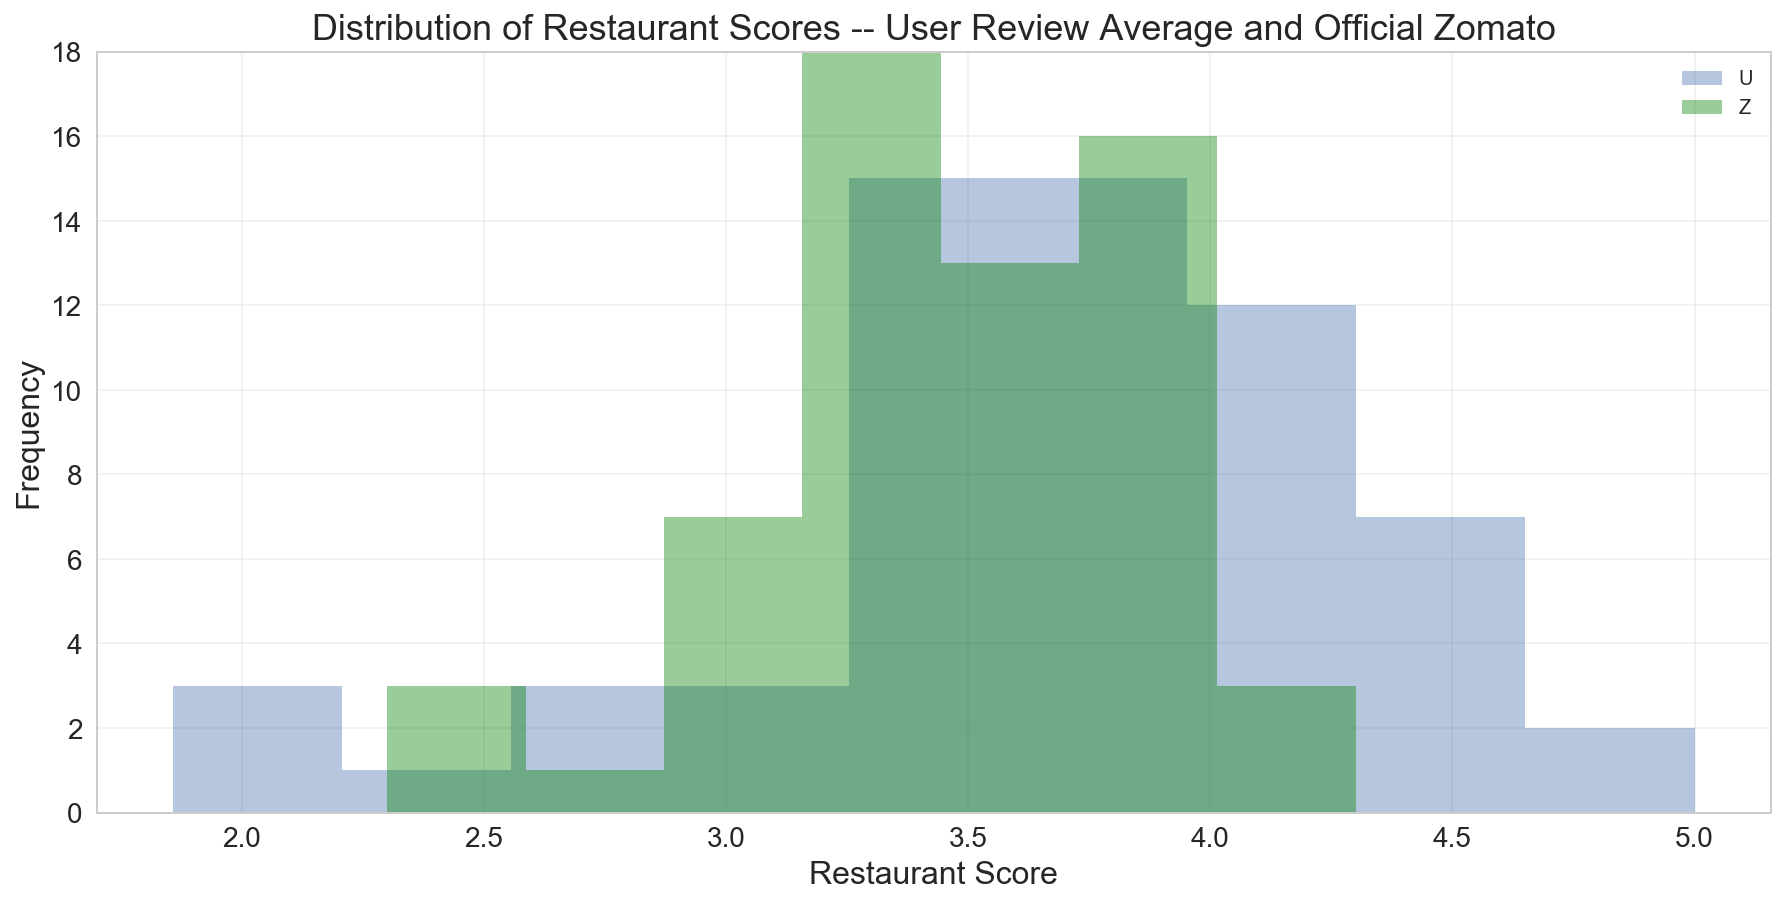

In [6]:
# plotting the distribution of restaurant scores based on Zomato scoring and User review scoring
plt.figure(figsize = (15,7))
plt.grid(alpha = 0.25)

plt.subplot(1,1,1), sns.distplot(df.groupby('restaurant')['user_rating'].mean(), kde = False);

plt.subplot(1,1,1), sns.distplot(df.groupby('restaurant')['restaurant_rating'].mean(), kde = False, color = 'g')
plt.title('Distribution of Restaurant Scores -- User Review Average and Official Zomato', fontsize = 18)
plt.xlabel('Restaurant Score', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.ylim((0,18))
plt.legend('UZ');

print('Zomato Mean = {}\nUser Mean = {}\n'.format(round(df['restaurant_rating'].mean(), 2), 
                                                  round(df['user_rating'].mean(), 2)))
                                                    
print('Zomato Median = {}\nUser Median = {}'.format(df['restaurant_rating'].median(),
                                                    df['user_rating'].median()))

Most of the User review scores are 3.5 and above. Lets have a look at how many reviews these restaurants actually have.

Restaurant	Num Reviews

Mamasita          1363
Misty's Diner      417
The Black Toro     367
Touché Hombre      356
Trippy Taco        296
Name: restaurant, dtype: int64


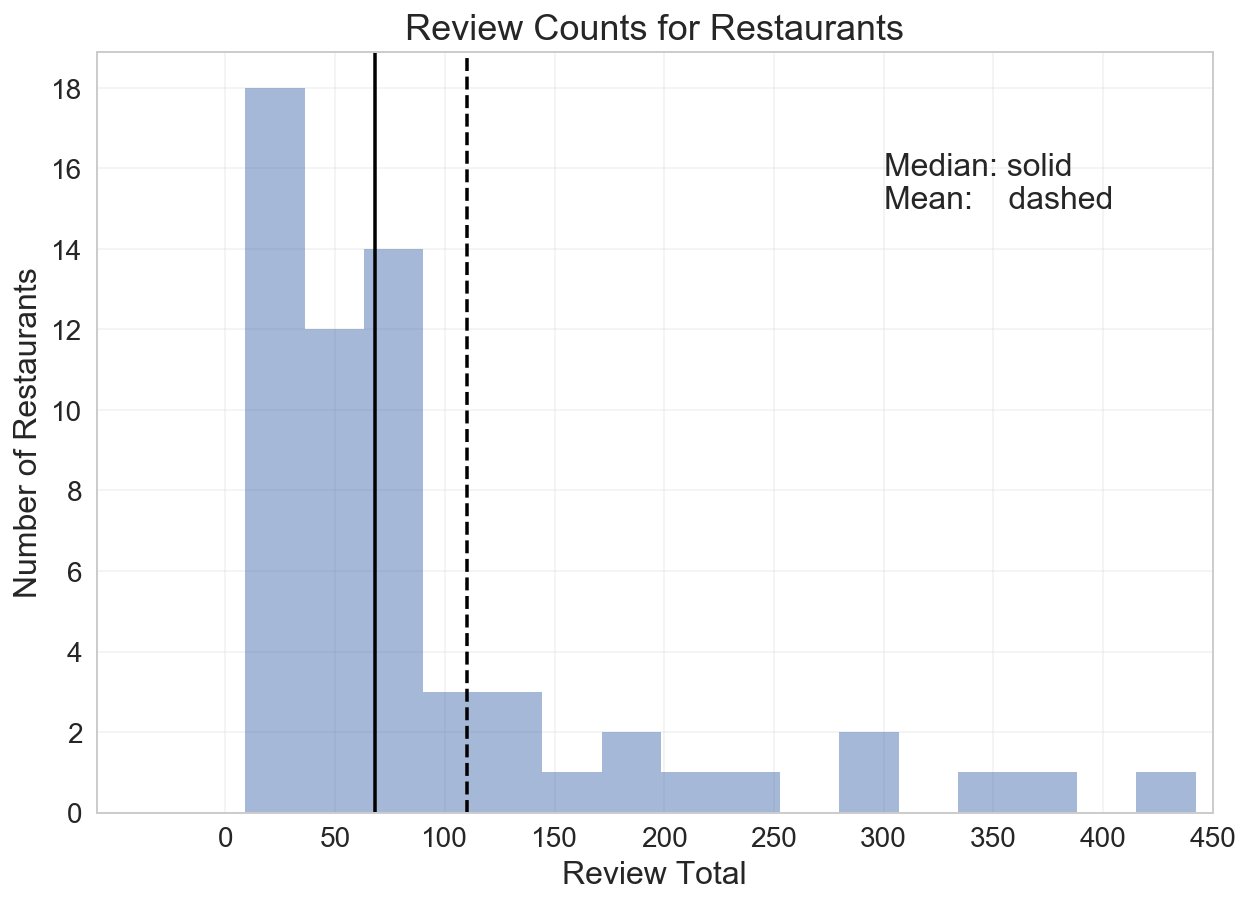

In [7]:
# plotting histogram of total reviews for restaurants
plt.figure(figsize = (10,7))
plt.grid(alpha = 0.2)
plt.hist(df.groupby('restaurant').count()['review_text'], bins = 50, alpha = 0.5)

plt.xlim(xmax = 450)
plt.axvline(df.groupby('restaurant').count()['review_text'].mean(), ls = '--', c = 'k')
plt.axvline(df.groupby('restaurant').count()['review_text'].median(), c = 'k')
plt.xticks(np.arange(0, 500, 50), fontsize=14)
plt.yticks(np.arange(0, 20, 2), fontsize=14)
plt.xlabel('Review Total', fontsize = 16)
plt.ylabel('Number of Restaurants', fontsize = 16)
plt.title('Review Counts for Restaurants', fontsize = 18)
plt.annotate('Median: solid\nMean:    dashed', xy = (300,15), fontsize = 16);

print('Restaurant\tNum Reviews\n')
print(df['restaurant'].value_counts().head())

Mamasita, the restaurant with 1,400 reviews is skewing the distribution of our counts. Either way, it looks like I will have around 50 reviews for most restaurants. Lets take this visualisation further and bolt on scores and prices.

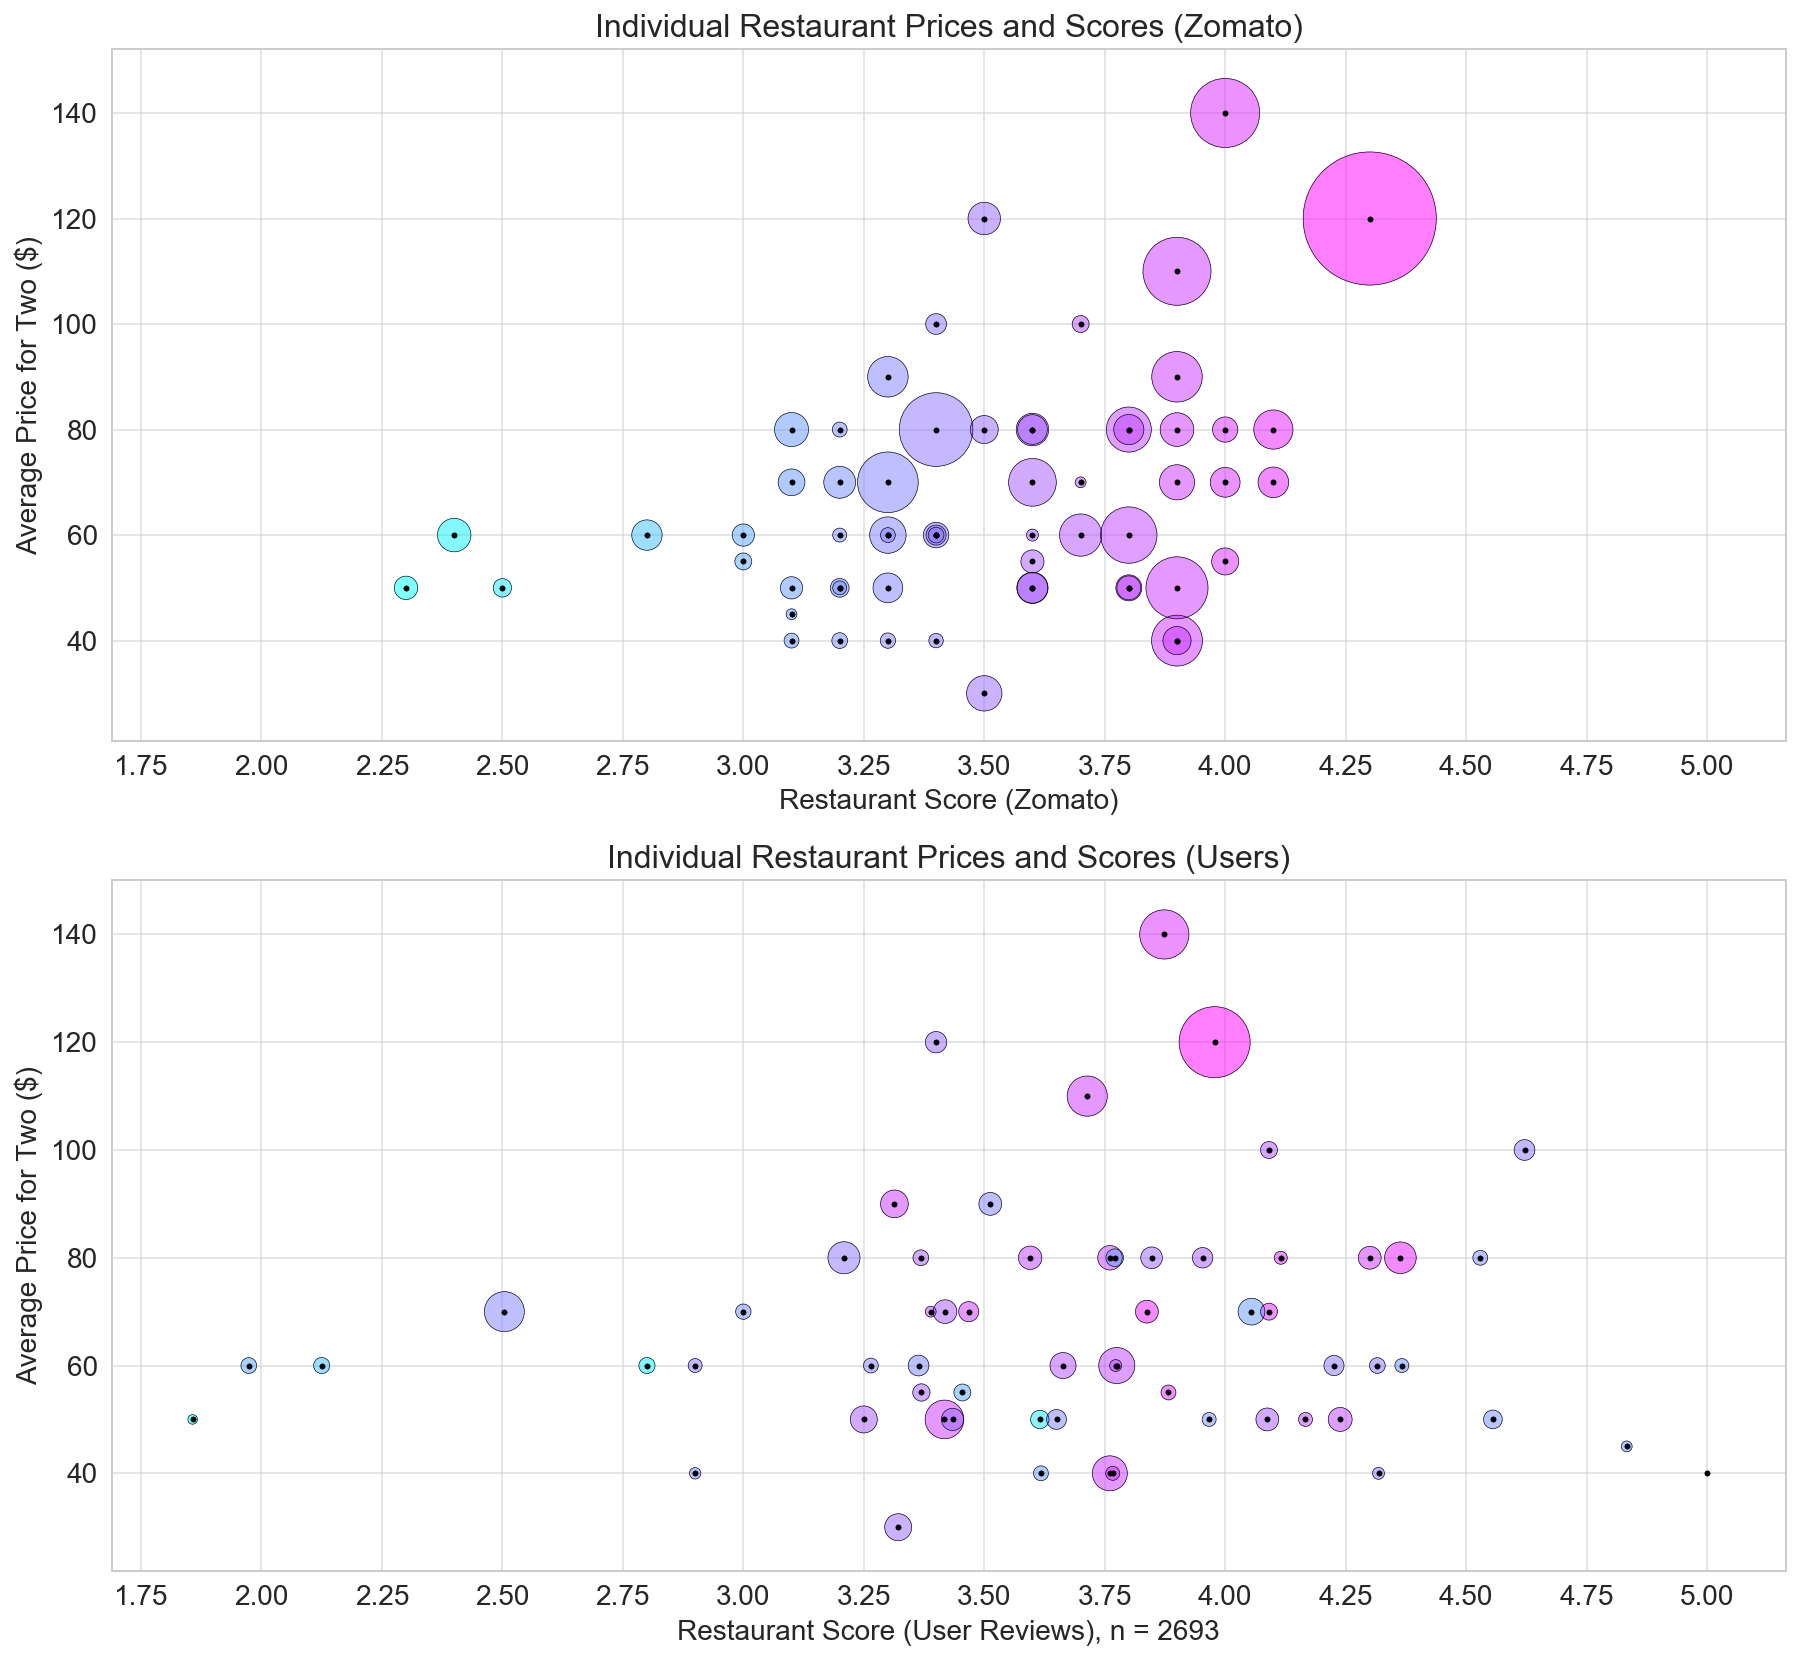

In [8]:
plt.figure(figsize = (15,14))

plt.subplot(2,1,1), plt.scatter(df.groupby('restaurant')['restaurant_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['restaurant_rating'].count()], 
            c  = df.groupby('restaurant')['restaurant_rating'].mean(), 
            alpha = 0.5, 
            cmap = 'cool');


plt.subplot(2,1,1), plt.scatter(df.groupby('restaurant')['restaurant_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = 7,
            c = 'k')

plt.subplot(2,1,1), plt.scatter(df.groupby('restaurant')['restaurant_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['restaurant_rating'].count()],
            facecolors='none', 
            edgecolors='k')

plt.xticks(np.arange(1.75, 5.25, 0.25))
plt.xlabel('Restaurant Score (Zomato)', fontsize = 14)
plt.ylabel('Average Price for Two ($)', fontsize = 14)
plt.title('Individual Restaurant Prices and Scores (Zomato)', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.grid(alpha = 0.5)

plt.subplot(2,1,2, sharex = plt.subplot(2,1,1)), plt.scatter(df.groupby('restaurant')['user_rating'].mean(),
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['user_rating'].count()],
            c  = df.groupby('restaurant')['restaurant_rating'].mean(),
            alpha = 0.5,
            cmap = 'cool');


plt.subplot(2,1,2, sharex = plt.subplot(2,1,1)) ,plt.scatter(df.groupby('restaurant')['user_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = 7,
            c = 'k')

plt.subplot(2,1,2, sharex = plt.subplot(2,1,1)), plt.scatter(df.groupby('restaurant')['user_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['user_rating'].count()],
            facecolors='none', 
            edgecolors='k')

plt.xticks(np.arange(1.75, 5.25, 0.25))
plt.xlabel('Restaurant Score (User Reviews), n = 2693', fontsize = 14)
plt.ylabel('Average Price for Two ($)', fontsize = 14)
plt.title('Individual Restaurant Prices and Scores (Users)', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.grid(alpha = 0.5)

# plt.savefig('subplots1.png', bbox_inches='tight', dpi=350)

These visualisations present a lot of information. Each bubble is a restaurant, and the size of the bubble indicates how many reviews each restaurant has.

The visualisation on the left utilises a restaurant's Zomato.com score. This is the score that takes all scores (regardless of if there was an accompanying review) into account. Zomato also does some behind the scene weighting to give more power to the scores given by credible users.

Conversely, The visualisation on the left scores each restaurant by taking the average of all scores that have an associated written review. This is why the bubbles have moved around. The size of the bubbles are smaller because of all of the reviews which don't have scores.

The visualisation on the left communicates a slight trend that the more money you spend the better your dining experience. Meanwhile, the visualisation on the right shows eighteen restaurants that have average scoress above 4.0.

### Feature Engineering - Aggregation of Restaurant and User Features (split-apply-combine)

In [9]:
def create_photos_per_review(data):
    '''Create feature of the ratio of photos to text reviews for each restaurant'''
    data['photos/review'] = data['num_photos'] / data['restaurant_reviews']
    return data

def create_average_rating(data):
    '''Create feature of the average user rating for each restaurant'''
    data['avg_rating'] = data['user_rating'].mean()
    return data

def create_average_user_rating(data):
    '''Create feature of the average user rating for each user'''
    data['avg_user_rating'] = data['user_rating'].mean()
    return data

def create_scoreless_reviews_count(data):
    '''Create feature of how many reviews don't have scores for each restaurant'''
    data['restaurant_scoreless_reviews'] = data['restaurant'].count() - data['user_rating'].count()
    return data

def create_user_review_average_likes(data):
    '''Create feature of the average number of likes a user's review gets, for each user'''
    data['user_avg_review_likes'] = data['review_likes'].mean()
    return data


df = df.groupby('restaurant').apply(create_photos_per_review)
df = df.groupby('restaurant').apply(create_average_rating)
df = df.groupby('user_id').apply(create_average_user_rating)
df = df.groupby('restaurant').apply(create_scoreless_reviews_count)
df = df.groupby('user_id').apply(create_user_review_average_likes)

In [10]:
df.head(3)

,review_id,review_likes,user_id,user_rating,user_url,restaurant,restaurant_id,restaurant_reviews,total_reviews,total_votes,num_photos,location,address,prices,user_total_reviews,user_location,user_total_photos,user_rank,user_tier,user_followers,user_leaderboard_rank,user_expert_hoods,review_text,restaurant_rating,restaurant_url,review_length,positive,mex_reviews,photos/review,avg_rating,avg_user_rating,restaurant_scoreless_reviews,user_avg_review_likes
0,31340172,1,6405,4.0,https://www.zomato.com/kritikajain86,Mexico City,16585644,122,438,1659,132,Bentleigh,"268 Centre Road, Bentleigh, Melbourne",80,14.0,Ludhiana,68.0,4.0,Big Foodie,80.0,0.0,0.0,there is a lot to say about this place but i w...,4.1,https://www.zomato.com/melbourne/mexico-city-b...,51,NaN,0,1.081967,4.363636,4.0,41,1.0
1,24623203,0,27513,4.5,https://www.zomato.com/users/ami-mehta-27513,Touché Hombre,16579110,398,356,1453,341,Melbourne,"233 Lonsdale Street, CBD, Melbourne, VIC",110,20.0,Mumbai,11.0,5.0,Big Foodie,117.0,0.0,0.0,excellent vegetarian food.. a rare find in a c...,3.9,https://www.zomato.com/melbourne/touché-hombre...,35,NaN,1,0.856784,3.713710,4.0,232,0.0
2,24623212,0,27513,3.5,https://www.zomato.com/users/ami-mehta-27513,Mamasita,16575238,1492,1689,9894,1328,Collins Street,"Level 1, 11 Collins Street, CBD, Melbourne",120,20.0,Mumbai,11.0,5.0,Big Foodie,117.0,0.0,0.0,finding good vegetarian food in melbourne is s...,4.3,https://www.zomato.com/melbourne/mamasita-coll...,48,NaN,1,0.890080,3.978093,4.0,975,0.0


### Feature Engineering - Sentiment Analysis

In [11]:
sen = pd.read_csv('sentiment_words_simple.csv')

In [12]:
sen.tail()

,pos,word,pos_score,neg_score
155282,verb,zone,0.0000,0.0625
155283,verb,zonk_out,0.0625,0.1875
155284,verb,zoom,0.0000,0.0000
155285,verb,zoom_along,0.0000,0.0000
155286,verb,zoom_in,0.1250,0.0000


In [13]:
sen['pos'] = sen['pos'].map(lambda x: x.upper())

In [14]:
sen['objectivity'] = 1.0 - (sen['pos_score'] + sen['neg_score'])
sen['pos_vs_neg'] = sen['pos_score'] - sen['neg_score']

In [15]:
# creating a dictionary that cotains all words for each part of speech with
# the corresponding objectivity and positive vs. negative scores

sen_dict = {'ADJ':{},'NOUN':{},'VERB':{},'ADV':{}}

for i, row in enumerate(sen.itertuples()):
    sen_dict[row[1]][row[2]] = {'objectivity':row[5], 'pos_vs_neg':row[6]}

In [16]:
del sen

In [17]:
import spacy
en_nlp = spacy.load('en')

In [18]:
temp = en_nlp(df['review_text'].values[0])
temp

there is a lot to say about this place but i will let the pictures do most of it! all i will say is that this place has great hosts and great food. a must-go if you love mexican. do book a table before you go as its generally jam packed!

In [19]:
for i, token in enumerate(temp):
    if i == 5:
        break
    print(token.pos_)

ADV
VERB
DET
NOUN
PART


In [20]:
parsed_quotes = []
for i, parsed in enumerate(en_nlp.pipe(df['review_text'].values, batch_size=50, n_threads=4)):
    assert parsed.is_parsed
    parsed_quotes.append(parsed)        

In [21]:
unique_pos = []
for parsed in parsed_quotes:
    unique_pos.extend([t.pos_ for t in parsed])
unique_pos = np.unique(unique_pos)
print(unique_pos)

['ADJ' 'ADP' 'ADV' 'CCONJ' 'DET' 'INTJ' 'NOUN' 'NUM' 'PART' 'PRON' 'PROPN'
 'PUNCT' 'SPACE' 'SYM' 'VERB' 'X']


In [22]:
for pos in unique_pos:
    df[pos+'_prop'] = 0.0

In [23]:
# df = df.reset_index(drop=True)
for i, parsed in enumerate(parsed_quotes):
    parsed_len = len(parsed)
    for pos in unique_pos:
        count = len([x for x in parsed if x.pos_ == pos])
        df.loc[i, pos+'_prop'] = float(count)/parsed_len

In [24]:
df.shape

(7244, 49)

In [25]:
null_idx = df[df['review_id'].isnull()].index
df.drop(null_idx, axis = 0, inplace = True)

In [26]:
df.shape

(6721, 49)

In [27]:
# for name, ser in df.loc[:,'ADJ_prop':].iteritems():
#     print(name)
#     print(ser.value_counts().head(3), '\n')

In [28]:
def scorer(parsed):
    obj_scores, pvn_scores = [], []
    for token in [t for t in parsed if t.pos_ in ['ADJ', 'ADP', 'ADV', 'CCONJ', 'DET', 
                                                  'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 
                                                  'PROPN', 'PUNCT', 'SPACE', 'SYM', 'VERB', 'X']]:
        try:
            obj_scores.append(sen_dict[token.pos_][str(token)]['objectivity'])
            pvn_scores.append(sen_dict[token.pos_][str(token)]['pos_vs_neg'])
        except:
            pass
    if len(obj_scores) == 0:
        obj_scores = [1.0]
    if len(pvn_scores) == 0:
        pvn_scores = [0.0]
    return [obj_scores, pvn_scores]

In [29]:
scores = []
for i, parsed in enumerate(parsed_quotes):
    scores.append(scorer(parsed))
    
df['objectivity_avg'] = [np.mean(x[0]) for x in scores]
df['pos_vs_neg_avg'] = [np.mean(x[1]) for x in scores]

In [30]:
for quote in df.sort_values('pos_vs_neg_avg', ascending=False)['review_text'][0:3]:
    print(quote)
    print('============================================================\n')

the best...

best nachos

best burritos!!!



In [31]:
for quote in df.sort_values('pos_vs_neg_avg', ascending=True)['review_text'][0:3]:
    print(quote)
    print('============================================================\n')

terrible everything!!

terrible, tasteless, lukewarm.

terrible, non-existent service, rude snooty staff, vile greasy food, over priced, bad music, not fun at all. do not bother.



In [32]:
for quote in df.sort_values('objectivity_avg', ascending=False)['review_text'][0:3]:
    print(quote)
    print('============================================================\n')

looooove!!!!

awesomw tequilla selection

muy buena atención, bastante rápido y diversidad en el menú. nos atendió un iraní muy amable y hasta nos habló español. un local organizado, limpio y con espacio necesario para sentirse cómodos. la comida estaba rica y bien presentada, un lugar muy recomendable para una comida rápida.



In [33]:
for quote in df.sort_values('objectivity_avg', ascending=True)['review_text'][0:3]:
    print(quote)
    print('============================================================\n')

amazing!!!!!!

prawn ceviche = delicious!

delicious!



In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, SGDRegressor, SGDClassifier, ElasticNetCV, LassoLarsCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, \
BaggingRegressor, BaggingClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from tpot import TPOTRegressor, TPOTClassifier 
from tpot.builtins import StackingEstimator

In [37]:
dfr = df[df['user_rating'].isnull() == False].copy()

In [40]:
X = dfr[['prices', 'user_followers', 'user_leaderboard_rank', 'review_length', 
         'mex_reviews', 'photos/review', 'user_avg_review_likes',
         'objectivity_avg','pos_vs_neg_avg','review_length']+[x for x in dfr.columns if x.endswith('_prop')]]

y = dfr['user_rating'].values

ss = StandardScaler()
Xs = ss.fit_transform(X)

scores = cross_val_score(RidgeCV(), Xs, y, cv=10)
print(scores)
print(np.mean(scores))

[ 0.15726283  0.18847945  0.28848148  0.35734758  0.2146797   0.3313482
  0.3327431   0.40074588  0.38410614  0.42696486]
0.308215921861


In [41]:
reg = RidgeCV().fit(Xs, y)
for var, coef in zip(X.columns, reg.coef_):
    print(var, coef)

prices 0.0732563431162
user_followers 0.0191943601207
user_leaderboard_rank 0.0026454877621
review_length -0.0556043942665
mex_reviews -0.026339957087
photos/review 0.0185068541847
user_avg_review_likes 0.0835695878293
objectivity_avg 0.138163839854
pos_vs_neg_avg 0.674986296778
review_length -0.0556043942665
ADJ_prop 0.00845982040239
ADP_prop -0.0110606206098
ADV_prop 0.0115794748266
CCONJ_prop -0.00817405892628
DET_prop -0.0878105202079
INTJ_prop -0.028496848544
NOUN_prop 0.0109406620662
NUM_prop 0.0242102197753
PART_prop -0.0105512422109
PRON_prop 0.0359999744539
PROPN_prop -0.00580286750347
PUNCT_prop -0.0232417325749
SPACE_prop 0.00829150320645
SYM_prop 0.0103762749644
VERB_prop 0.0154888677045
X_prop -0.00887150259298


In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [43]:
analyzer = SentimentIntensityAnalyzer()
for sentence in df['review_text'].values[0:2]:
    vs = analyzer.polarity_scores(sentence)
    print(sentence)
    print(vs)

there is a lot to say about this place but i will let the pictures do most of it! all i will say is that this place has great hosts and great food. a must-go if you love mexican. do book a table before you go as its generally jam packed!
{'neg': 0.0, 'neu': 0.709, 'pos': 0.291, 'compound': 0.9669}
excellent vegetarian food.. a rare find in a city like melbourne. i ordered the corn on cob and pumpkin nachos.. both were really good.. the guacomole had a nice flavour too. brilliant ambiance.. must visit!
{'neg': 0.0, 'neu': 0.673, 'pos': 0.327, 'compound': 0.92}


In [44]:
df['vader_neg'] = 0
df['vader_pos'] = 0
df['vader_neu'] = 0
df['vader_compound'] = 0

for i, q in enumerate(df['review_text'].values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']

In [45]:
dfr = df[df['user_rating'].isnull() == False].copy()

In [46]:
X = dfr[['review_likes', 'restaurant_reviews', 'mex_reviews', 'prices', 'user_total_reviews', 'user_followers',
         'vader_neg','vader_pos','vader_neu','vader_compound','review_length',
         'objectivity_avg','pos_vs_neg_avg','review_length']+[x for x in dfr.columns if x.endswith('_prop')]]

y = dfr['user_rating']

Xs = StandardScaler().fit_transform(X)

scores = cross_val_score(RidgeCV(), Xs, y, cv=10)
print(scores)
print(np.mean(scores))

# We do slightly better. I've also left out the part of speech stuff so that has an impact too.

[ 0.2765894   0.39984358  0.46660208  0.47453782  0.48036794  0.50548687
  0.4834751   0.52196644  0.53319893  0.55043943]
0.469250759305


### Training model to predict if a review is positive or not

In [47]:
# instantiating indices for reviews that have numerical ratings and reviews that have sentiment ratings
rating_idx = df[df['user_rating'].isnull() == False].index
sentiment_idx = df[df['positive'].isnull() == False].index

dfr = df.loc[rating_idx].copy()
dfc = df.loc[sentiment_idx].copy()

In [48]:
columns = dfc.drop(['review_id', 'user_id', 'user_rating', 'user_url', 'restaurant', 
                    'restaurant_id', 'restaurant_reviews', 'total_reviews',
                    'total_votes', 'num_photos','location', 'address', 'user_location', 
                    'user_tier', 'user_expert_hoods', 'review_text', 
                    'restaurant_url', 'positive', 'avg_user_rating'], axis = 1).columns

In [49]:
dfc.columns

Index(['review_id', 'review_likes', 'user_id', 'user_rating', 'user_url',
       'restaurant', 'restaurant_id', 'restaurant_reviews', 'total_reviews',
       'total_votes', 'num_photos', 'location', 'address', 'prices',
       'user_total_reviews', 'user_location', 'user_total_photos', 'user_rank',
       'user_tier', 'user_followers', 'user_leaderboard_rank',
       'user_expert_hoods', 'review_text', 'restaurant_rating',
       'restaurant_url', 'review_length', 'positive', 'mex_reviews',
       'photos/review', 'avg_rating', 'avg_user_rating',
       'restaurant_scoreless_reviews', 'user_avg_review_likes', 'ADJ_prop',
       'ADP_prop', 'ADV_prop', 'CCONJ_prop', 'DET_prop', 'INTJ_prop',
       'NOUN_prop', 'NUM_prop', 'PART_prop', 'PRON_prop', 'PROPN_prop',
       'PUNCT_prop', 'SPACE_prop', 'SYM_prop', 'VERB_prop', 'X_prop',
       'objectivity_avg', 'pos_vs_neg_avg', 'vader_neg', 'vader_pos',
       'vader_neu', 'vader_compound'],
      dtype='object')

In [50]:
subset = ['review_likes','prices','user_total_reviews','user_total_photos', 
'user_rank','user_followers','review_length','mex_reviews','photos/review',
'user_avg_review_likes', 'ADJ_prop',
'ADP_prop', 'ADV_prop', 'CCONJ_prop', 'DET_prop', 'INTJ_prop',
'NOUN_prop', 'NUM_prop', 'PART_prop', 'PRON_prop', 'PROPN_prop',
'PUNCT_prop', 'SPACE_prop', 'SYM_prop', 'VERB_prop', 'X_prop',
'objectivity_avg', 'pos_vs_neg_avg', 'vader_neg', 'vader_pos',
'vader_neu', 'vader_compound']

In [51]:
dfc_sub = dfc.loc[:,subset].copy()

In [52]:
clf = LogisticRegression()
scores = cross_val_score(clf, dfc_sub, dfc['positive'], cv = 10)
print('{}\n{}'.format(np.mean(scores), scores))

0.8556380533649943
[ 0.84565916  0.84516129  0.83225806  0.85806452  0.8516129   0.82847896
  0.86731392  0.86084142  0.87378641  0.89320388]


An r<sup>2</sup> of 0.85 isn't bad for throwing everything at the model.

In [53]:
# using slices to create train and test in order to keep indicies, so that additional features can be
# bolted on after the TfidifVectorizer runs.

# initialising TFIDF vectoriser
cv = TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words = 'english')

# vectorise review text
X_train = pd.DataFrame(cv.fit_transform(dfc['review_text'][:2400]).todense(), columns = cv.get_feature_names())
X_test = pd.DataFrame(cv.transform(dfc['review_text'][2400:]).todense(), columns = cv.get_feature_names())

# concatenate features to vertorised text
X_train = pd.concat([dfc[['prices', 'user_followers', 'user_leaderboard_rank', 
                          'review_length', 'mex_reviews', 'photos/review', 
                          'user_avg_review_likes', 'objectivity_avg',
                          'VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                          'vader_compound']][:2400].reset_index(drop=True), X_train], axis = 1)

X_test = pd.concat([dfc[['prices', 'user_followers', 'user_leaderboard_rank',
                         'review_length', 'mex_reviews', 'photos/review', 
                         'user_avg_review_likes', 'objectivity_avg',
                         'VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                         'vader_compound']][2400:].reset_index(drop=True), X_test], axis = 1)

# z-score features only
ss = StandardScaler()
X_train.iloc[:,:13] = ss.fit_transform(X_train.iloc[:,:13])
X_test.iloc[:,:13] = ss.transform(X_test.iloc[:,:13])


# y_train
y_train = dfc['positive'][:2400].values

# y_test
y_test = dfc['positive'][2400:].values

In [54]:
baseline = dfc.loc[:,'positive'].mean()
baseline

0.6831395348837209

In [55]:
clf = RandomForestClassifier(random_state = 101)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.91379310344827591

An r<sup>2</sup> of 0.91 is even better. Lets try TPOT.

In [56]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LogisticRegression(C=1.0, dual=True, penalty="l2")),
    LogisticRegression())

exported_pipeline.fit(X_train, y_train)
test_preds = exported_pipeline.predict(X_test)
print(exported_pipeline.score(X_test, y_test))

0.949712643678


In [57]:
print(pd.crosstab(y_test, test_preds, rownames = ['actual'], colnames = ['Classifications'], margins = True))

Classifications  0.0  1.0  All
actual                        
0.0              182   21  203
1.0               14  479  493
All              196  500  696


35 misclassifications out of 696, or a 5% misclassification rate. I am confident enough in this to train the model on all of the sentiment reviews, and use the model to predict sentiment for the numerical reviews, and reviews with nothing

In [58]:
no_sentiment_idx = df[df.index.isin(sentiment_idx) == False].index
dfns = df.loc[no_sentiment_idx].copy()

In [59]:
cv = TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words = 'english')

words_sent = pd.DataFrame(cv.fit_transform(dfc['review_text']).todense(), columns = cv.get_feature_names())
words_no_sent = pd.DataFrame(cv.transform(dfns['review_text']).todense(), columns = cv.get_feature_names())

words_sent = pd.concat([dfc[['prices', 'user_followers', 'user_leaderboard_rank', 
                             'review_length', 'mex_reviews', 'photos/review', 
                             'user_avg_review_likes', 'objectivity_avg',
                             'VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                             'vader_compound']].reset_index(drop=True), words_sent], axis = 1)

words_no_sent = pd.concat([dfns[['prices', 'user_followers', 'user_leaderboard_rank', 
                                 'review_length', 'mex_reviews', 'photos/review', 
                                 'user_avg_review_likes', 'objectivity_avg',
                                 'VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                                 'vader_compound']].reset_index(drop=True), words_no_sent], axis = 1)

words_sent.iloc[:,:13] = ss.fit_transform(words_sent.iloc[:,:13])
words_no_sent.iloc[:,:13] = ss.transform(words_no_sent.iloc[:,:13])

words_train = dfc.loc[:, 'positive'].values

In [60]:
exported_pipeline.fit(words_sent, words_train)
preds_rate = exported_pipeline.predict(words_no_sent)

In [61]:
# imputing positive prediction feature into reviews with scores
df.loc[no_sentiment_idx, 'positive_predictions'] = pd.Series(data = preds_rate, index = no_sentiment_idx)

# masking true sentiment from positive feature to positive prediction feature
df.loc[sentiment_idx, 'positive_predictions'] = dfc['positive']

In [62]:
# every entry has sentiment
df['positive_predictions'].isnull().sum()

0

### Training model to predict review scores

In [63]:
dfr = df.loc[rating_idx].copy()

In [64]:
cv = TfidfVectorizer(max_features=500, ngram_range=(1,2), stop_words = 'english', strip_accents = 'ascii')

X_train = pd.DataFrame(cv.fit_transform(dfr['review_text'][:1900]).todense(), columns = cv.get_feature_names())
X_test = pd.DataFrame(cv.transform(dfr['review_text'][1900:]).todense(), columns = cv.get_feature_names())

X_train = pd.concat([dfr[['prices', 'positive_predictions', 'user_followers', 'user_leaderboard_rank', 
                          'review_length', 'mex_reviews', 'photos/review', 'user_avg_review_likes',
                          'objectivity_avg','VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                          'vader_compound']][:1900].reset_index(drop=True), X_train], axis = 1)

X_test = pd.concat([dfr[['prices', 'positive_predictions', 'user_followers', 'user_leaderboard_rank', 
                         'review_length', 'mex_reviews', 'photos/review', 'user_avg_review_likes',
                         'objectivity_avg','VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                         'vader_compound']][1900:].reset_index(drop=True), X_test], axis = 1)

X_train.iloc[:,:14] = ss.fit_transform(X_train.iloc[:,:14])
X_test.iloc[:,:14] = ss.transform(X_test.iloc[:,:14])

y_train = df.loc[rating_idx, 'user_rating'][:1900].values
y_test = df.loc[rating_idx, 'user_rating'][1900:].values

In [65]:
reg = RandomForestRegressor(n_estimators = 200, random_state= 101)
# reg = ExtraTreesRegressor(n_estimators = 200, random_state = 101)
# reg = BaggingRegressor(RidgeCV(), random_state = 101)
# reg = RidgeCV()
# reg = BaggingRegressor(SVR(kernel = 'linear', C = 0.5))
# reg = SGDRegressor()
# reg = GradientBoostingRegressor(n_estimators= 100)
# reg = BaggingRegressor(GradientBoostingRegressor(n_estimators= 100))
# reg = LinearSVR()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.68763273708233852

r<sup>2</sup> of 0.69. Lets try TPOT

In [66]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=False, max_features=0.15, 
                                                    min_samples_leaf=8, min_samples_split=16, n_estimators=100)),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.25, tol=0.001)),
    ExtraTreesRegressor(bootstrap=True, max_features=0.15, 
                        min_samples_leaf=2, min_samples_split=6, n_estimators=200)
)

exported_pipeline.fit(X_train, y_train)
exported_pipeline.score(X_test, y_test)


0.71162574061691031

In [67]:
no_rating_idx = df[df.index.isin(rating_idx) == False].index
dfnr = df.loc[no_rating_idx].copy()

In [73]:
cv = TfidfVectorizer(max_features=500, ngram_range=(1,2), stop_words = 'english')

words_rate = pd.DataFrame(cv.fit_transform(dfr['review_text']).todense(), columns = cv.get_feature_names())
words_no_rate = pd.DataFrame(cv.transform(dfnr['review_text']).todense(), columns = cv.get_feature_names())

words_rate = pd.concat([dfr[['prices', 'positive_predictions', 'user_followers', 
                             'user_leaderboard_rank', 'review_length', 'mex_reviews', 
                             'photos/review', 'user_avg_review_likes', 'objectivity_avg',
                             'VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                             'vader_compound']].reset_index(drop=True), words_rate], axis = 1)

words_no_rate = pd.concat([dfnr[['prices', 'positive_predictions', 'user_followers', 
                                 'user_leaderboard_rank', 'review_length', 'mex_reviews', 
                                 'photos/review', 'user_avg_review_likes', 'objectivity_avg',
                                 'VERB_prop', 'vader_neg', 'vader_pos','vader_neu', 
                                 'vader_compound']].reset_index(drop=True), words_no_rate], axis = 1)

words_rate.iloc[:,:14] = ss.fit_transform(words_rate.iloc[:,:14])
words_no_rate.iloc[:,:14] = ss.transform(words_no_rate.iloc[:,:14])

words_rate_test = dfr['user_rating'].values

In [75]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=False, max_features=0.15, 
                                                    min_samples_leaf=8, min_samples_split=16, n_estimators=100)),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.25, tol=0.001)),
    ExtraTreesRegressor(bootstrap=True, max_features=0.15, 
                        min_samples_leaf=2, min_samples_split=6, n_estimators=200)
)

exported_pipeline.fit(words_rate, words_rate_test)
preds_rating = exported_pipeline.predict(words_no_rate)

In [76]:
df.loc[no_rating_idx, 'rating_predictions'] = pd.Series(data = preds_rating, 
                                                        index = no_rating_idx)

# masking true rating from user_rating feature to rating prediction feature
df.loc[rating_idx, 'rating_predictions'] = pd.Series(df['user_rating'].loc[rating_idx])

In [77]:
# df.to_csv('results.csv')

In [78]:
df['rating_predictions'] = df['rating_predictions'].apply(lambda x: round(x * 2) / 2)

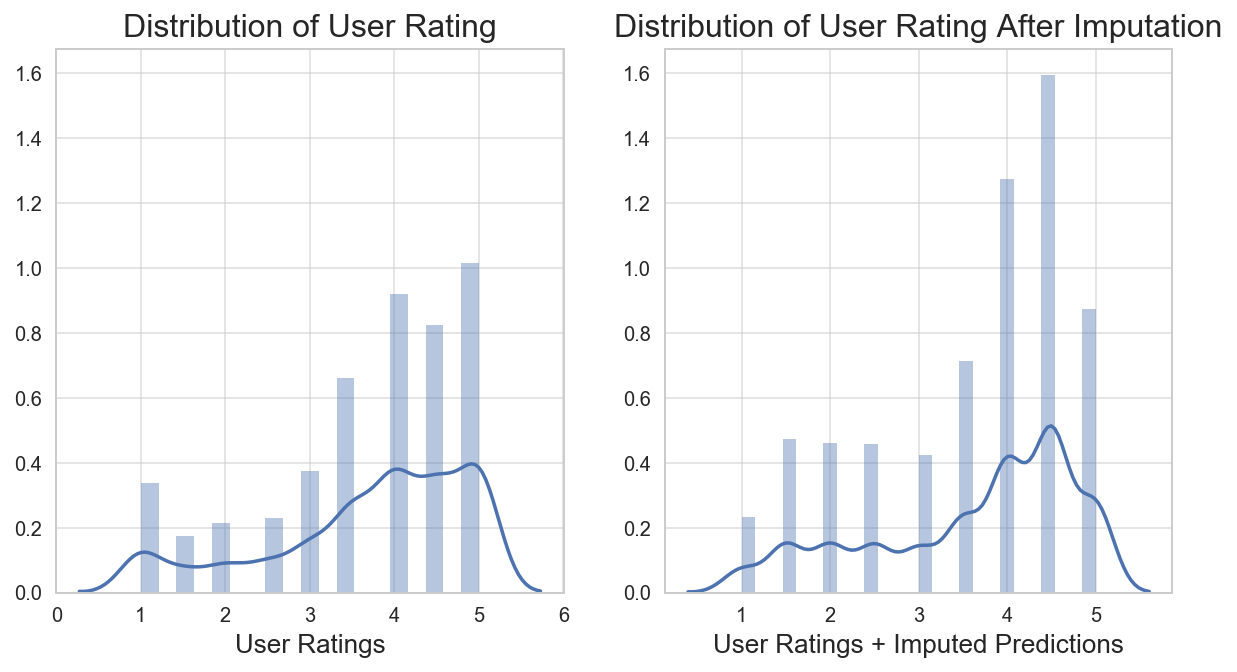

In [79]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1), sns.distplot(dfr['user_rating'])
plt.grid(alpha = 0.5)
plt.title('Distribution of User Rating', fontsize = 16)
plt.xlabel('User Ratings', fontsize = 13)

plt.subplot(1,2,2, sharey = plt.subplot(1,2,1)), sns.distplot(df['rating_predictions'])
plt.title('Distribution of User Rating After Imputation', fontsize = 16)
plt.xlabel('User Ratings + Imputed Predictions', fontsize = 13)
plt.grid(alpha = 0.5);

# plt.savefig('subplots3.png', bbox_inches='tight', dpi=350)

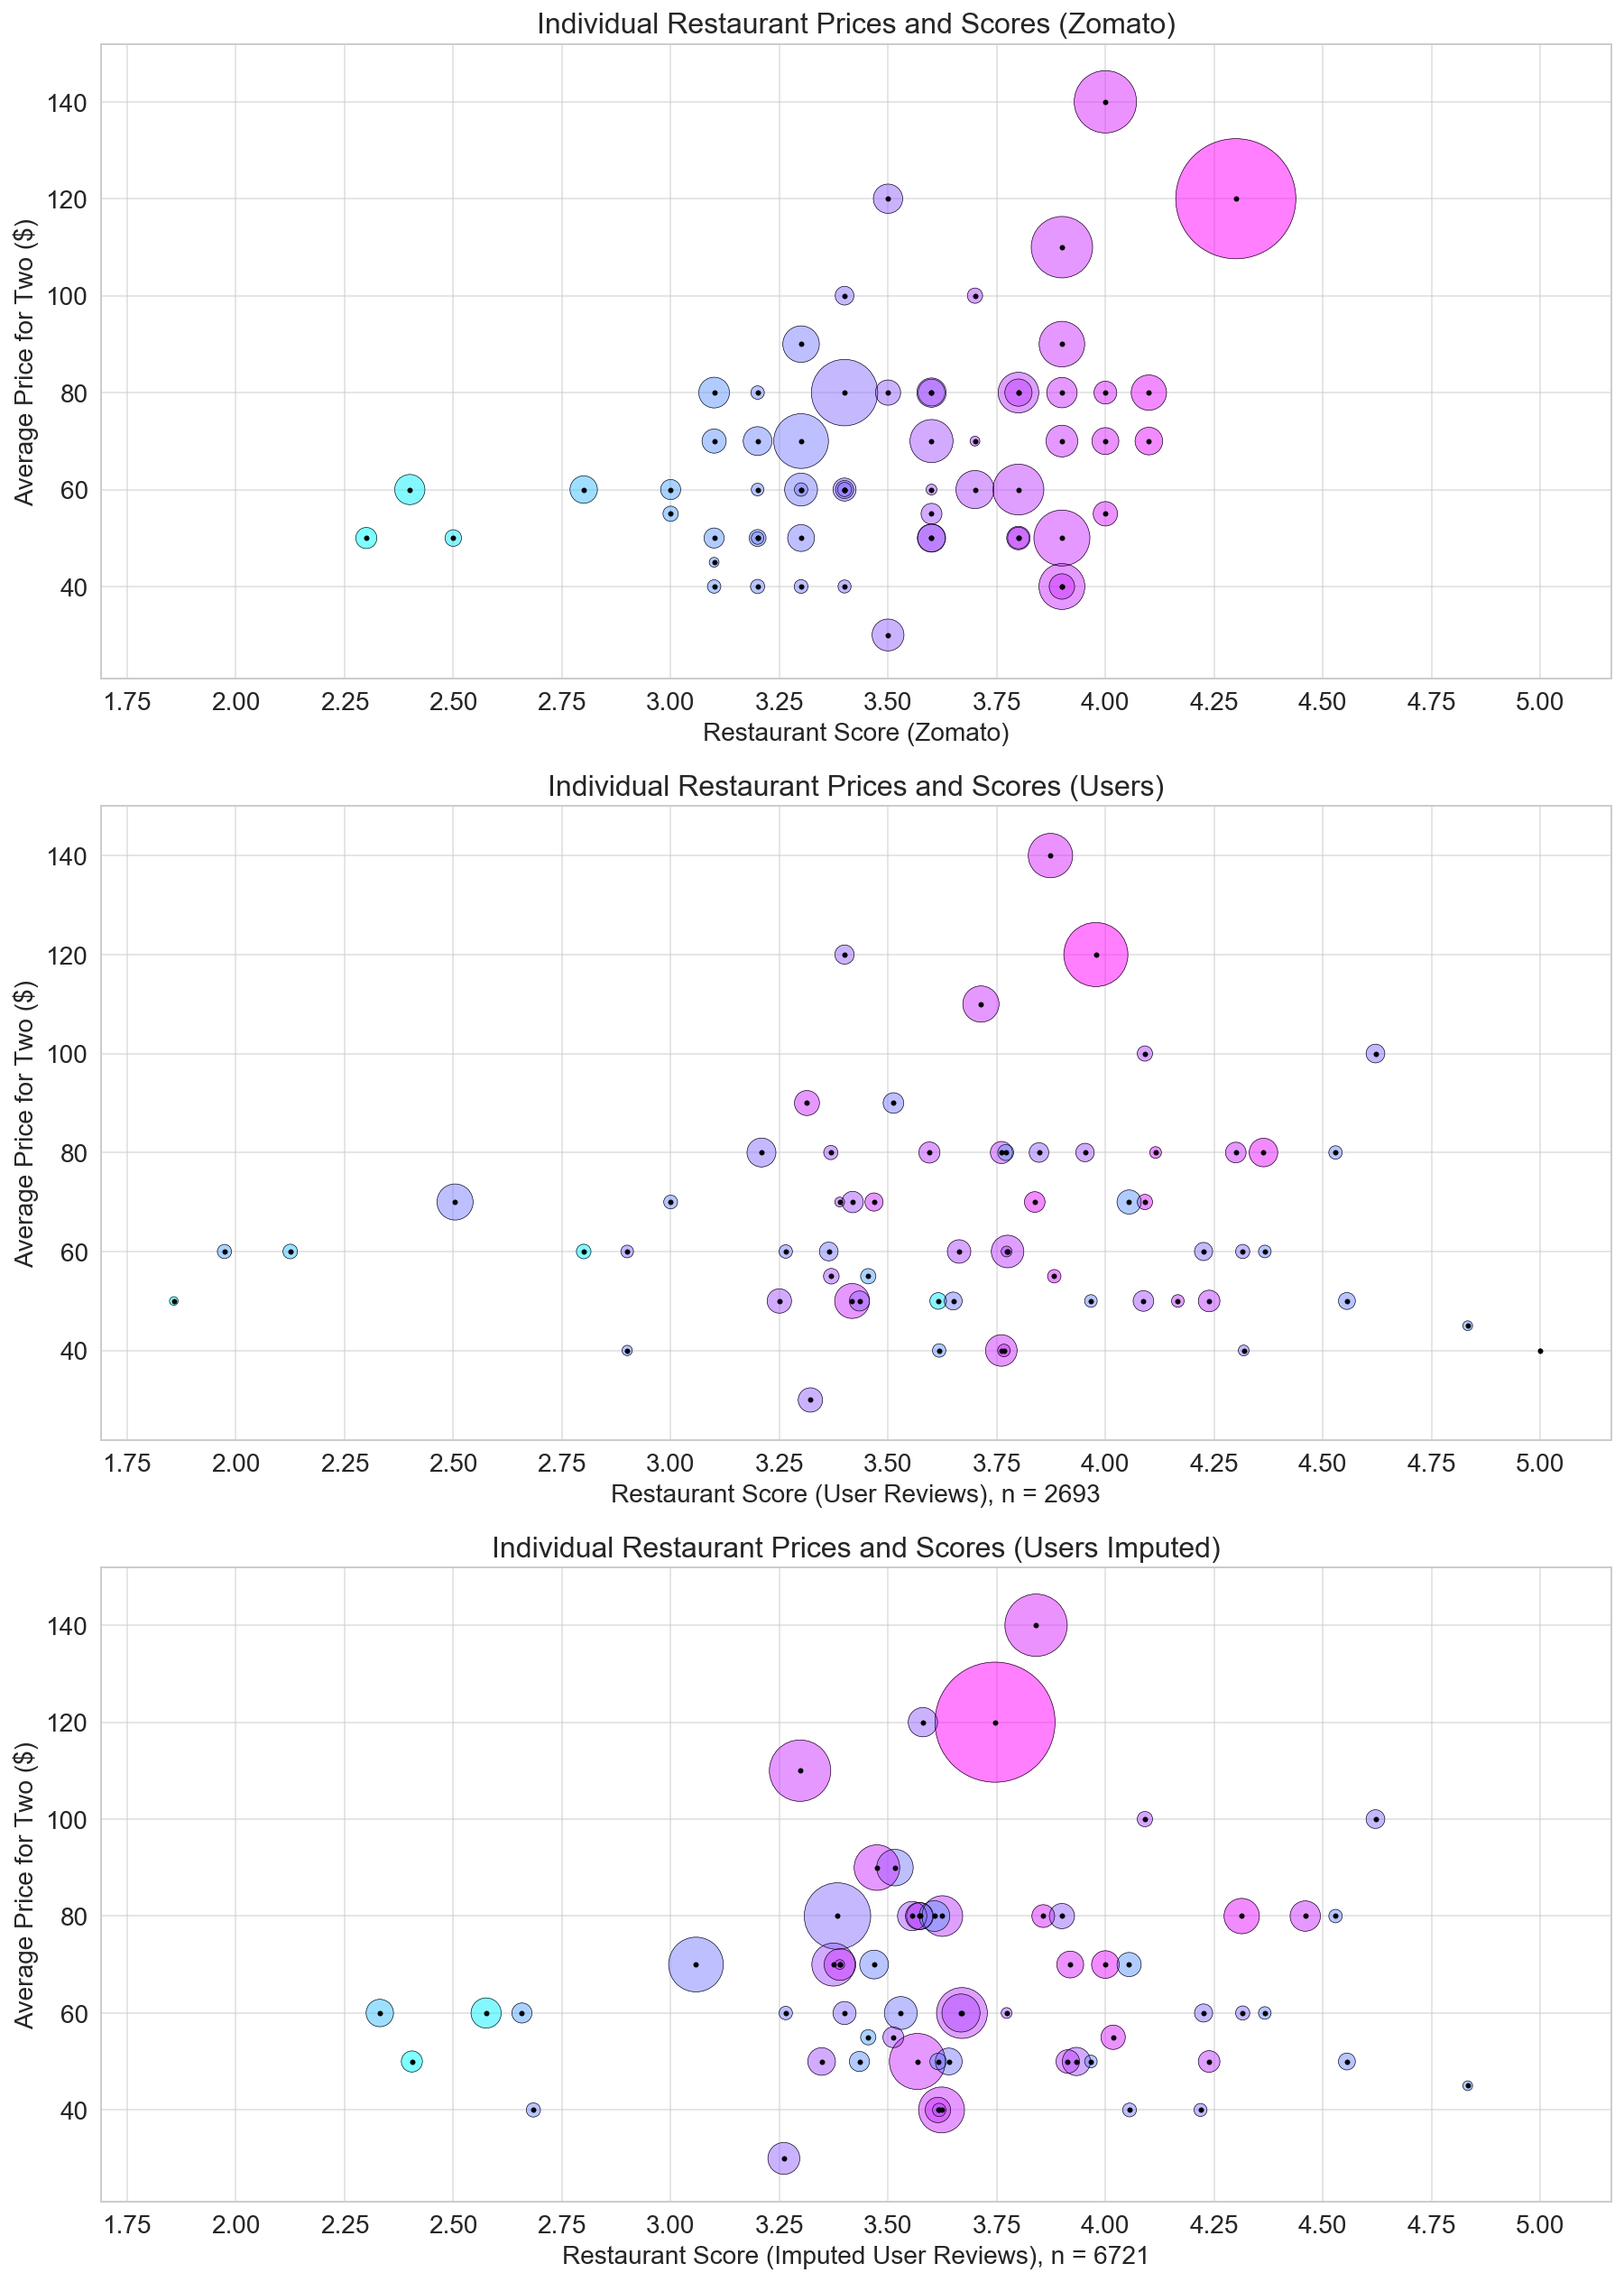

In [80]:
plt.figure(figsize = (15,22))

plt.subplot(3,1,1), plt.scatter(df.groupby('restaurant')['restaurant_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['restaurant_rating'].count()], 
            c  = df.groupby('restaurant')['restaurant_rating'].mean(), 
            alpha = 0.5, 
            cmap = 'cool');


plt.subplot(3,1,1), plt.scatter(df.groupby('restaurant')['restaurant_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = 7,
            c = 'k')

plt.subplot(3,1,1), plt.scatter(df.groupby('restaurant')['restaurant_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['restaurant_rating'].count()],
            facecolors='none', 
            edgecolors='k')

plt.xticks(np.arange(1.75, 5.25, 0.25))
plt.xlabel('Restaurant Score (Zomato)', fontsize = 14)
plt.ylabel('Average Price for Two ($)', fontsize = 14)
plt.title('Individual Restaurant Prices and Scores (Zomato)', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.grid(alpha = 0.5)

plt.subplot(3,1,2, sharex = plt.subplot(3,1,1)), plt.scatter(df.groupby('restaurant')['user_rating'].mean(),
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['user_rating'].count()],
            c  = df.groupby('restaurant')['restaurant_rating'].mean(),
            alpha = 0.5,
            cmap = 'cool');


plt.subplot(3,1,2, sharex = plt.subplot(3,1,1)) ,plt.scatter(df.groupby('restaurant')['user_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = 7,
            c = 'k')

plt.subplot(3,1,2, sharex = plt.subplot(3,1,1)), plt.scatter(df.groupby('restaurant')['user_rating'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['user_rating'].count()],
            facecolors='none', 
            edgecolors='k')

plt.xticks(np.arange(1.75, 5.25, 0.25))
plt.xlabel('Restaurant Score (User Reviews), n = 2693', fontsize = 14)
plt.ylabel('Average Price for Two ($)', fontsize = 14)
plt.title('Individual Restaurant Prices and Scores (Users)', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.grid(alpha = 0.5)


plt.subplot(3,1,3, sharex = plt.subplot(3,1,1)), plt.scatter(df.groupby('restaurant')['rating_predictions'].mean(),
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['rating_predictions'].count()],
            c  = df.groupby('restaurant')['restaurant_rating'].mean(),
            alpha = 0.5,
            cmap = 'cool');


plt.subplot(3,1,3, sharex = plt.subplot(3,1,1)) ,plt.scatter(df.groupby('restaurant')['rating_predictions'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = 7,
            c = 'k')

plt.subplot(3,1,3, sharex = plt.subplot(3,1,1)), plt.scatter(df.groupby('restaurant')['rating_predictions'].mean(), 
            df.groupby('restaurant')['prices'].mean(),
            s = [x * 3.25 for x in df.groupby('restaurant')['rating_predictions'].count()],
            facecolors='none', 
            edgecolors='k')

plt.xticks(np.arange(1.75, 5.25, 0.25))
plt.xlabel('Restaurant Score (Imputed User Reviews), n = 6721', fontsize = 14)
plt.ylabel('Average Price for Two ($)', fontsize = 14)
plt.title('Individual Restaurant Prices and Scores (Users Imputed)', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.grid(alpha = 0.5)

# plt.savefig('subplots2.png', bbox_inches='tight', dpi=350)

In [85]:
# gby = df.groupby('restaurant').mean()[['restaurant_rating', 'user_rating', 'rating_predictions', 'restaurant_scoreless_reviews']]
# gby.index.name=None
# gby['diff'] = gby['user_rating'] - gby['rating_predictions']
# # gby['user_mean'] = df['user_rating'].mean()
# # gby['pred_mean'] = df['rating_predictions'].mean()
# gby = gby[gby['diff'] != 0.00].copy()
# gby['impute_dir'] = gby['diff'].apply(lambda x: '-' if x > 0 else '+')

In [82]:
print('User Rating Mean:    {}\nImputed Rating Mean: {}'.format(df['user_rating'].mean(), df['rating_predictions'].mean()))

User Rating Mean:    3.6851095432603045
Imputed Rating Mean: 3.6011010266329415


## The two funniest reviews I was able to find throughout this project

In [83]:
for rev in df['review_text']:
    if 'bender' in rev:
        print(rev)

came here during a bender, lost my bike and wanted to feel better. had some delicious tacos and margis. i think it was cheap but i don't remember. i found my bike when i went back to my friends house.


In [84]:
for rev in df['review_text']:
    if 'monumental failure' in rev:
        print(rev)

mexico city was quite naturally perfect. it was, a work of art, flawless, sublime, a triumph equalled only by its monumental failure. one out of five.
